# Milestone P4 :

### Through this project we propose new figures and analysis to the "Predicting present with Google Trends paper.

For this creative extension, we are going to answer to these three following questions: 

- Does the model improve the prediction over the base model for the initial claims data ?
- Is the model consistent with other time series ?
- Has Google Trends the power to help us predict one-month-ahead movements of the USD/EUR rate ?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_absolute_error
import statistics
from statsmodels.tsa.seasonal import seasonal_decompose
from colorama import Fore

## Q1 : Does the model improve the prediction over the base model for the initial claims data ?
#### How can we improve the prediction model? Which parameters have a significant impact on the prediction? 

In the paper, a simple linear regression with a seasonal term is used to predict the initial claims for unemployment benefits. Besides the indication of which trend categories were used to improve the prediction, very few details were provided. This model is very basic and is probably not the most performant. We will try to see in this section which parameters can help us to improve the predictions and generalize the model to adapt it to diffenrent types of datasets. 

In [32]:
# Load iclaims Data :
data_iclaims = pd.read_csv('merged_iclaims.csv')
# Reshape of the DataFrame into a more convenient form :
data_iclaims.Index = pd.to_datetime(data_iclaims.Index)
# Relevant turning points for analysis :
idx1 = data_iclaims.loc[data_iclaims['Index'].isin(['2009-03-07'])].index.tolist()[0] 
idx2 = data_iclaims.loc[data_iclaims['Index'].isin(['2009-05-02'])].index.tolist()[0]
idx3 = data_iclaims.loc[data_iclaims['Index'].isin(['2009-12-05'])].index.tolist()[0]
idx4 = data_iclaims.loc[data_iclaims['Index'].isin(['2010-02-06'])].index.tolist()[0]
idx5 = data_iclaims.loc[data_iclaims['Index'].isin(['2010-07-10'])].index.tolist()[0]
idx6 = data_iclaims.loc[data_iclaims['Index'].isin(['2010-07-17'])].index.tolist()[0]
idx7 = data_iclaims.loc[data_iclaims['Index'].isin(['2011-01-01'])].index.tolist()[0]
idx8 = data_iclaims.loc[data_iclaims['Index'].isin(['2011-05-07'])].index.tolist()[0]

data_iclaims = data_iclaims.set_index(data_iclaims['Index'])
data_iclaims.index = pd.DatetimeIndex(data_iclaims.index.values,freq='W-SAT') # Indicate that our index is sampled by weeks
data_iclaims.rename(columns = {'claims.sa':'claims_sa'}, inplace = True)
data_iclaims.rename(columns = {'claims.nsa':'claims_nsa'}, inplace = True)
data_iclaims.rename(columns = {'Welfare...Unemployment':'WelfareUnemployment'}, inplace = True)

# Data preprocessing :
data_iclaims['claims_sa']= np.log(data_iclaims['claims_sa'])
data_iclaims['claims_nsa']= np.log(data_iclaims['claims_nsa'])
data_iclaims['s1sa']=data_iclaims['claims_sa'].shift(1,axis=0,fill_value=0) # create seasonnal term for sa claims
data_iclaims.head()

,Index,claims_sa,claims_nsa,Jobs,WelfareUnemployment,s1sa
2004-01-10,2004-01-10,12.777052,13.426751,6.066862,-7.574152,0.000000
2004-01-17,2004-01-17,12.799399,13.103717,-3.558773,-25.237886,12.777052
2004-01-24,2004-01-24,12.774223,12.853862,-6.184409,-17.401619,12.799399
2004-01-31,2004-01-31,12.837344,12.914842,-7.935044,-18.815352,12.774223
2004-02-07,2004-02-07,12.847927,12.979033,-13.310680,-24.104085,12.837344


### Model without rolling window

This model forecasts initial claims for unemployments benefits. We will do exactly like in the paper, which is to use a simple linear regression with seasonal terms for the Baseline model and Google Trends for the Trends model. We first try to replicate the two Anova tables from the paper to make sure that our model is consistent. Then we plot a new figure close to the one that we already replicated (Figure 2), but using the iclaims predictions this time.

### Baseline model :

We only use a seasonnal term $y_{t-1}$ for the linear regression.

In [33]:
mod = smf.ols(formula = 'claims_sa ~ s1sa', data= data_iclaims[1:] )
res = mod.fit()
Predictions = res.predict()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              claims_sa   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     9480.
Date:                Sun, 13 Dec 2020   Prob (F-statistic):          9.22e-275
Time:                        15:43:46   Log-Likelihood:                 669.17
No. Observations:                 390   AIC:                            -1334.
Df Residuals:                     388   BIC:                            -1326.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2549      0.130      1.968      0.0

### Trends model :

We use the seasonnal term $y_{t-1}$ and the Google Trends "Jobs", "Welfare & Unemployment".

In [34]:
# Trends Model :
mod_trends = smf.ols(formula = 'claims_sa ~ s1sa + Jobs + WelfareUnemployment', data= data_iclaims[1:] )
res_trends = mod_trends.fit()
Predictions_trends = res_trends.predict()
print(res_trends.summary())

                            OLS Regression Results                            
Dep. Variable:              claims_sa   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     3261.
Date:                Sun, 13 Dec 2020   Prob (F-statistic):          9.62e-274
Time:                        15:43:49   Log-Likelihood:                 676.05
No. Observations:                 390   AIC:                            -1344.
Df Residuals:                     386   BIC:                            -1328.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.0563    

### MAEs :

According to the tables in the paper, we should start forecasting on the 17th of January 2004 (idx = 1) and end on the 2nd of July 2011 (idx = 391). We evaluate the MAEs at the given turning points in the paper. However, our dataset is constructed such that we cannot predict the exact same dates. Thus, our goal is to approximate the given turning points by close enough time intervals available in our dataset. Some differences in the forecasting improvement between Base and Trend model are expected. 

In [35]:
#Overall period
mae_base_overall = mean_absolute_error(data_iclaims.claims_sa[1:],Predictions)/(data_iclaims.claims_sa[1:].mean())
mae_trends_overall = mean_absolute_error(data_iclaims.claims_sa[1:],Predictions_trends)/(data_iclaims.claims_sa[1:].mean())
improvement_overall = (mae_base_overall-mae_trends_overall)/mae_base_overall*100

#Period 1
mae_base_turningpoint = mean_absolute_error(data_iclaims.claims_sa[idx1:idx2],Predictions[idx1-1:idx2-1])/(data_iclaims.claims_sa[idx1:idx2].mean())
mae_trends_turningpoint = mean_absolute_error(data_iclaims.claims_sa[idx1:idx2],Predictions_trends[idx1-1:idx2-1])/(data_iclaims.claims_sa[idx1:idx2].mean())
improvement_turningpoint = (mae_base_turningpoint-mae_trends_turningpoint)/mae_base_turningpoint*100

#Period 2
mae_base_turningpoint_2 = mean_absolute_error(data_iclaims.claims_sa[idx3:idx4],Predictions[idx3-1:idx4-1])/(data_iclaims.claims_sa[idx3:idx4].mean())
mae_trends_turningpoint_2 = mean_absolute_error(data_iclaims.claims_sa[idx3:idx4],Predictions_trends[idx3-1:idx4-1])/(data_iclaims.claims_sa[idx3:idx4].mean())
improvement_turningpoint_2 = (mae_base_turningpoint_2-mae_trends_turningpoint_2)/mae_base_turningpoint_2*100

#Period 3
mae_base_turningpoint_3 = np.abs(data_iclaims.claims_sa[idx6]-Predictions[idx6-1])/(data_iclaims.claims_sa[idx6])
mae_trends_turningpoint_3 = np.abs(data_iclaims.claims_sa[idx6]-Predictions_trends[idx6-1])/(data_iclaims.claims_sa[idx6])
improvement_turningpoint_3 = (mae_base_turningpoint_3-mae_trends_turningpoint_3)/mae_base_turningpoint_3*100

#Period 3
mae_base_turningpoint_4 = mean_absolute_error(data_iclaims.claims_sa[idx7:idx8],Predictions[idx7-1:idx8-1])/(data_iclaims.claims_sa[idx7:idx8].mean())
mae_trends_turningpoint_4 = mean_absolute_error(data_iclaims.claims_sa[idx7:idx8],Predictions_trends[idx7-1:idx8-1])/(data_iclaims.claims_sa[idx7:idx8].mean())
improvement_turningpoint_4 = (mae_base_turningpoint_4-mae_trends_turningpoint_4)/mae_base_turningpoint_4*100

### Plots :

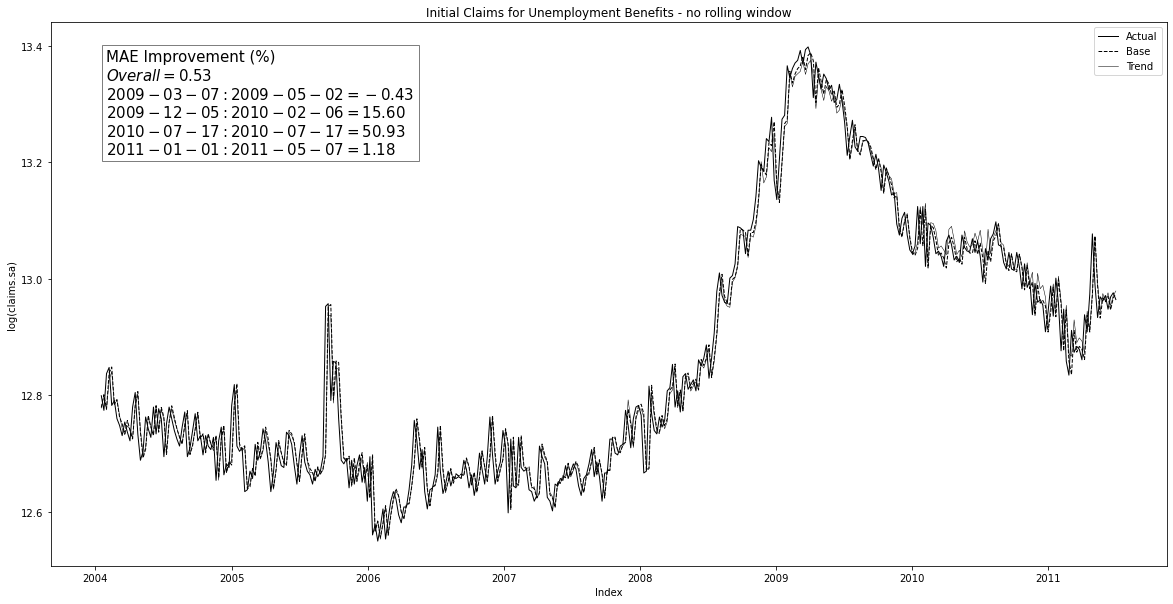

In [37]:
#Plots :
fig,ax = plt.subplots()
ax.plot(data_iclaims['Index'][1:],data_iclaims['claims_sa'][1:],color='black',label='Actual',linewidth=1)
ax.plot(data_iclaims['Index'][1:],Predictions,linestyle='--',color='black',label='Base',linewidth=1)
ax.plot(data_iclaims['Index'][1:],Predictions_trends,color='black',linewidth=0.5,label='Trend')
plt.legend()
textstr = '\n'.join((
    r'MAE Improvement (%)',
    r'$Overall=%.2f$'%(improvement_overall,),
    r'$2009-03-07: 2009-05-02=%.2f$'%(improvement_turningpoint,),
    r'$2009-12-05 : 2010-02-06=%.2f$'%(improvement_turningpoint_2,),
    r'$2010-07-17 : 2010-07-17=%.2f$'%(improvement_turningpoint_3,),
    r'$2011-01-01 : 2011-05-07=%.2f$'%(improvement_turningpoint_4,)))
    
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        verticalalignment='top',bbox=dict(facecolor='white', alpha=0.5))
ax.set_ylabel('log(claims.sa)')
ax.set_xlabel('Index')
ax.set_title('Initial Claims for Unemployment Benefits - no rolling window')
fig.set_size_inches(20,10)
plt.show()

Now, we are going to try to modify 2 parameters: 
- the number of seasonal terms 
- training set of the model 

### 1. Seasonal Terms

Does the number of seasonal terms on impact the prediction accuracy of the autoregressive model?  
We are going to predict the overall initial claims by using different seasonal terms and find out what are their impact on the prediction accuracy. 

In [42]:
#Number of seasonal terms to test : 2,6,9,12

data_iclaims['s2sa']=data_iclaims['claims_sa'].shift(2,axis=0,fill_value=0)
data_iclaims['s6sa']=data_iclaims['claims_sa'].shift(6,axis=0,fill_value=0)
data_iclaims['s8sa']=data_iclaims['claims_sa'].shift(8,axis=0,fill_value=0)
data_iclaims['s12sa']=data_iclaims['claims_sa'].shift(12,axis=0,fill_value=0)

mod4 = smf.ols(formula = 'claims_sa ~ s1sa + s2sa ', data= data_iclaims[1:] )
mod4_trends = smf.ols(formula = 'claims_sa ~ s1sa +s2sa + Jobs + WelfareUnemployment', data= data_iclaims[1:] )
res = mod4.fit()
res_trends = mod4_trends.fit()
Predictions = res.predict()
Predictions_trends = res_trends.predict()
mae_base_overall = mean_absolute_error(data_iclaims.claims_sa[1:],Predictions)/(data_iclaims.claims_sa[1:].mean())
mae_trends_overall = mean_absolute_error(data_iclaims.claims_sa[1:],Predictions_trends)/(data_iclaims.claims_sa[1:].mean())
improvement_overall = (mae_base_overall-mae_trends_overall)/mae_base_overall*100
print('With the seasonal term t = ',2,'the MAE improvement is ',improvement_overall,'%')


mod1 = smf.ols(formula = 'claims_sa ~ s1sa + s6sa ', data= data_iclaims[1:] )
mod1_trends = smf.ols(formula = 'claims_sa ~ s1sa +s6sa + Jobs + WelfareUnemployment', data= data_iclaims[1:] )
res = mod1.fit()
res_trends = mod1_trends.fit()
Predictions = res.predict()
Predictions_trends = res_trends.predict()
mae_base_overall = mean_absolute_error(data_iclaims.claims_sa[1:],Predictions)/(data_iclaims.claims_sa[1:].mean())
mae_trends_overall = mean_absolute_error(data_iclaims.claims_sa[1:],Predictions_trends)/(data_iclaims.claims_sa[1:].mean())
improvement_overall = (mae_base_overall-mae_trends_overall)/mae_base_overall*100
print('With the seasonal term t = ',6,'the MAE improvement is ',improvement_overall,'%')

mod2 = smf.ols(formula = 'claims_sa ~ s1sa +s9sa', data= data_iclaims[1:] )
mod2_trends = smf.ols(formula = 'claims_sa ~ s1sa +s9sa + Jobs + WelfareUnemployment', data= data_iclaims[1:] )
res = mod2.fit()
res_trends = mod2_trends.fit()
Predictions = res.predict()
Predictions_trends = res_trends.predict()
mae_base_overall = mean_absolute_error(data_iclaims.claims_sa[1:],Predictions)/(data_iclaims.claims_sa[1:].mean())
mae_trends_overall = mean_absolute_error(data_iclaims.claims_sa[1:],Predictions_trends)/(data_iclaims.claims_sa[1:].mean())
improvement_overall = (mae_base_overall-mae_trends_overall)/mae_base_overall*100
print('With the seasonal term t = ',8,'the MAE improvement is ',improvement_overall,'%')


mod3 = smf.ols(formula = 'claims_sa ~ s1sa +s12sa ', data= data_iclaims[1:] )
mod3_trends = smf.ols(formula = 'claims_sa ~ s1sa +s12sa+ Jobs + WelfareUnemployment ', data= data_iclaims[1:] )
res = mod3.fit()
res_trends = mod3_trends.fit()
Predictions = res.predict()
Predictions_trends = res_trends.predict()
mae_base_overall = mean_absolute_error(data_iclaims.claims_sa[1:],Predictions)/(data_iclaims.claims_sa[1:].mean())
mae_trends_overall = mean_absolute_error(data_iclaims.claims_sa[1:],Predictions_trends)/(data_iclaims.claims_sa[1:].mean())
improvement_overall = (mae_base_overall-mae_trends_overall)/mae_base_overall*100
print('With the seasonal term t = ',12,'the MAE improvement is ',improvement_overall,'%')


With the seasonal term t =  2 the MAE improvement is  0.5452274228213825 %
With the seasonal term t =  6 the MAE improvement is  0.5688932998997158 %
With the seasonal term t =  8 the MAE improvement is  0.5503837330150595 %
With the seasonal term t =  12 the MAE improvement is  0.514543422844398 %


With only the previous observation, the MAE improvement was 0.53%. Using the observation until 6 months before we can achieve better predictions. However, after 6 months, taking more observations increase more the MAE, which means that late observations are not very useful to predict the present and that the most important observations are the one that are close in time to the prediction we want to make.

### 2. Using a rolling window

Does the size of the training set impact the prediction accuracy? 

The principle of using a rolling window is to use a certain number k of previous observations to train the model predict the next one. 

In [44]:
#Rolling window with k = 17 observations.
k = [2,3,4,5,6,8,10,12]

for n in k: 
    #Base model
    preds=[]
    for i in range(n,len(data_iclaims)): 
        x_train = data_iclaims.iloc[i-n:i-1,:]
        mod = smf.ols(formula='claims_sa ~  s1sa +s8sa ',data=x_train)
        res = mod.fit()
        pred = res.params[0] + res.params[1]*data_iclaims.s1sa[i]
        preds.append(pred)
    
    #Trends model
    preds_trend = []
    for i in range(n,len(data_iclaims)): 
        x_train = data_iclaims.iloc[i-n:i-1,:]
        mod = smf.ols(formula='claims_sa ~  s1sa+s8sa+Jobs + WelfareUnemployment',data=x_train)
        res = mod.fit()
        pred = res.params[0] + res.params[1]*data_iclaims['s1sa'][i] + res.params[2]*data_iclaims['Jobs'][i]+ res.params[3]*data_iclaims['WelfareUnemployment'][i]
        preds_trend.append(pred)
    
    mae_base_overall = mean_absolute_error(data_iclaims.claims_sa[n:],preds)/(data_iclaims.claims_sa[n:].mean())
    mae_trends_overall = mean_absolute_error(data_iclaims.claims_sa[n:],preds_trend)/(data_iclaims.claims_sa[n:].mean())
    improvement_overall = (mae_base_overall-mae_trends_overall)/mae_base_overall*100
    print('With the rolling window of size ',n,' the MAE improvent is ',improvement_overall,'%')



With the rolling window of size  2  the MAE improvent is  -59.81992543611273 %
With the rolling window of size  3  the MAE improvent is  55.07885186416347 %
With the rolling window of size  4  the MAE improvent is  83.26696688239107 %
With the rolling window of size  5  the MAE improvent is  -160.2113066883825 %
With the rolling window of size  6  the MAE improvent is  -847.6360090727165 %
With the rolling window of size  8  the MAE improvent is  -155.85589072485837 %
With the rolling window of size  10  the MAE improvent is  -97.91137417360987 %
With the rolling window of size  12  the MAE improvent is  -75.44927749780491 %


In this case, using a rolling window does does improve the prediction when using Google Trends when the rolling window is of size 3 and 4 and the seasonal term 's8sa'. But it may depends on the dataset we have and the allure of the observations.  

In fine, modeling the parameters of the autoregressive linear model, we can see that we are able to reach better predictions, and we can also notice that more complex models generally achieve better predictions. Also, the time period on which we train our model also seems to be significant on the prediction.

## Q2 :Is the model consistent with other time series ? Is the model accurate when we try to perform out-of-sample forecasting?

We will try to forecast the same dataset (initial claims) but for another time series (2011 to 2020) and see we will try to see if the model is consistent and effective on another time period. Indeed, for now we have only predicted observations that we already've known. What if we improve the model based on what we've done on the previous section and try to predict the future with that. Because in the end of the day, what will the companies want is to have models that can predict the future over a few months with reliable models. 

The idea here will be to train the model on a specific time serie where the observations are known, but predict on another time serie with unknown observations and see if the model with google trends helps to be more precise and improves the predictions. 

In [48]:
# Load The datasets
jobs = pd.read_csv('Emploi.csv')
WU = pd.read_csv('Aide_chomage.csv')
claims = pd.read_csv('ICSA.csv')


# Reshape Jobs in a more convenient form :
jobs = jobs.reset_index()
jobs.rename(columns = {'index':'DATE'}, inplace = True)
jobs.rename(columns = {'Catégorie\xa0: Emploi':'Jobs'}, inplace = True)
jobs = jobs.drop([0])


# Make sure values are float and <1 is converted to 0
jobs['Jobs']= [float(s.replace('<\xa01','0')) for s in jobs['Jobs']]

# Reshape Welfare&Unemployement in a more convenient form :
WU = WU.reset_index()
WU.rename(columns = {'index':'DATE'}, inplace = True)
WU.rename(columns = {'Catégorie\xa0: Aide sociale et chômage':'Unemployment'}, inplace = True)
WU = WU.drop([0])

# Make sure values are float and <1 is converted to 0
WU['Unemployment']= [float(s.replace('<\xa01','0')) for s in WU['Unemployment']]

# claims has weekly observations of iclaims and trends has monthly observations.
# To solve this issue, we calculate the monthly average for iclaims. We already select the time frame of interest
# 2011-2020
idx = jobs.loc[jobs['DATE'].isin(['2011-01'])].index.tolist()[0] 
idx2 = claims.loc[claims['DATE'].isin(['2011-01-01'])].index.tolist()[0]
ICSA = claims['ICSA'][idx2:].values
    
# Finally we create a clean dataframe with all the required features
iclaims = pd.DataFrame({'DATE':jobs['DATE'][idx-1:],'Jobs':jobs['Jobs'][idx-1:],'Unemployment':WU['Unemployment'][idx-1:],'ICSA':ICSA}).reset_index().drop('index', axis=1)
iclaims.DATE = pd.to_datetime(iclaims.DATE)
iclaims = iclaims.set_index(iclaims['DATE'])
#iclaims.index = pd.DatetimeIndex(iclaims.index.values,freq='MS') # Indicate that our index is sampled by months


### Preprocessing :

In [49]:
# Data preprocessing :
iclaims['ICSA']= np.log(iclaims['ICSA'])
iclaims['s1']=iclaims['ICSA'].shift(1,axis=0,fill_value=0) # create seasonnal term for sa claims
# Make sure the values are floats

### Baseline model :

We only use a seasonnal term $y_{t-1}$ for the linear regression.

In [50]:
mod = smf.ols(formula = 'ICSA ~ s1', data= iclaims[1:] )
res = mod.fit()
Predictions = res.predict()

### Trends model :

We use the seasonnal term $y_{t-1}$ and the Google Trends "Jobs", "Welfare & Unemployment".

In [51]:
# Trends Model :
mod_trends = smf.ols(formula = 'ICSA ~ s1 + Jobs + Unemployment', data=iclaims[1:] )
res_trends = mod_trends.fit()
Predictions_trends = res_trends.predict()

### MAEs :

We evaluate the overall MAEs, as we don't know the turning points. Finding turning points will be one goal of the figure analysis.

In [52]:
mae_base_overall = mean_absolute_error(iclaims.ICSA[1:],Predictions)/(iclaims.ICSA[1:].mean())
mae_trends_overall = mean_absolute_error(iclaims.ICSA[1:],Predictions_trends)/(iclaims.ICSA[1:].mean())
improvement_overall = (mae_base_overall-mae_trends_overall)/mae_base_overall*100

In [53]:
print('MAE Trends Overall =',mae_trends_overall)
print('MAE Base Overall =',mae_base_overall)

MAE Trends Overall = 0.010719130641822464
MAE Base Overall = 0.013322739354737474


### Plots :

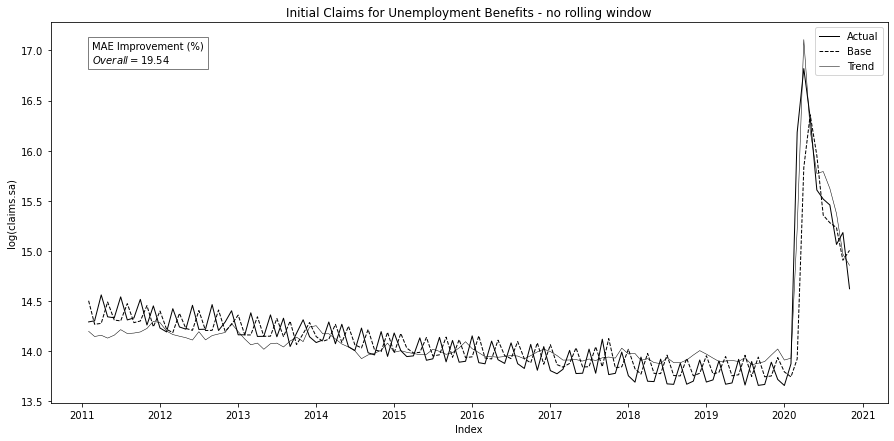

In [54]:
#Plots :

fig,ax = plt.subplots()
ax.plot(iclaims['DATE'][1:],iclaims['ICSA'][1:],color='black',label='Actual',linewidth=1)
ax.plot(iclaims['DATE'][1:],Predictions,linestyle='--',color='black',label='Base',linewidth=1)
ax.plot(iclaims['DATE'][1:],Predictions_trends,color='black',linewidth=0.5,label='Trend')
plt.legend()
textstr = '\n'.join((
    r'MAE Improvement (%)',
    r'$Overall=%.2f$'%(improvement_overall,)))
    
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top',bbox=dict(facecolor='white', alpha=0.5))
ax.set_ylabel('log(claims.sa)')
ax.set_xlabel('Index')
ax.set_title('Initial Claims for Unemployment Benefits - no rolling window')
fig.set_size_inches(15,7)
plt.show()

# Out of sample forecasting 

Now we will focus on the main goal of this model and find out the real impact of the google trends. 
The purpose of using this kind of model is to predict over a time series (for the next one or two months) for which we don't know the observations, and not simply predict on the timeline we trained the model on. 
As we can see on the previous graph, there is an important and sudden increase of intial claims in 2020 so it could be interesting to see if the autoregressive models can predict it, training only the models until january 2020 and predict on 2020. 

In [59]:
df = iclaims[:-10]
olsmod = smf.ols(formula='ICSA ~  s1  ',data=df)
olsres = olsmod.fit()

df_new = iclaims[-10:]

preds = []
for i in range(0,len(df_new)): 
    pred = olsres.params[0] + olsres.params[1]*df_new.s1[i] 
    preds.append(pred)

print(olsres.summary())   

                            OLS Regression Results                            
Dep. Variable:                   ICSA   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8630
Date:                Sun, 13 Dec 2020   Prob (F-statistic):              0.355
Time:                        16:16:34   Log-Likelihood:               -0.81766
No. Observations:                 109   AIC:                             5.635
Df Residuals:                     107   BIC:                             11.02
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.2574      0.242     58.874      0.0

In [60]:

olsmod_trends = smf.ols(formula='ICSA ~  s1 + Jobs + Unemployment  ',data=df)
olsres_trends = olsmod_trends.fit()

preds_trends = []
for i in range(0,len(df_new)): 
    pred = olsres_trends.params[0] + olsres_trends.params[1]*df_new.s1[i]  + olsres_trends.params[2]*df_new.Jobs[i] + df_new.Unemployment[i]*olsres_trends.params[3]
    preds_trends.append(pred)


print(olsres_trends.summary())

                            OLS Regression Results                            
Dep. Variable:                   ICSA   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     56.38
Date:                Sun, 13 Dec 2020   Prob (F-statistic):           8.56e-22
Time:                        16:16:35   Log-Likelihood:                 51.047
No. Observations:                 109   AIC:                            -94.09
Df Residuals:                     105   BIC:                            -83.33
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       14.2232      0.231     61.503   

In [63]:
mae_base2020= mean_absolute_error(df_new.ICSA[-10:],preds)/(df_new.ICSA[-10:].mean())
mae_trends2020 = mean_absolute_error(df_new.ICSA[-10:],preds_trends)/(df_new.ICSA[-10:].mean())
improvement2020 = (mae_base2020-mae_trends2020)/mae_base2020*100

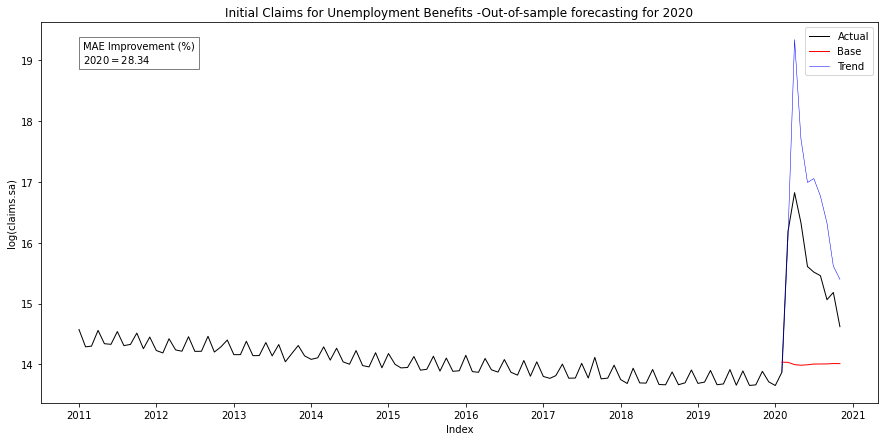

In [62]:
#Plots :

fig,ax = plt.subplots()
ax.plot(iclaims['DATE'],iclaims['ICSA'],color='black',label='Actual',linewidth=1)
ax.plot(df_new['DATE'],preds,linestyle='-',color='r',label='Base',linewidth=1)
ax.plot(df_new['DATE'],preds_trends,color='b',linewidth=0.5,label='Trend')
plt.legend()
textstr = '\n'.join((
    r'MAE Improvement (%)',
    r'$2020=%.2f$'%(improvement2020,)))
    
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top',bbox=dict(facecolor='white', alpha=0.5))
ax.set_ylabel('log(claims.sa)')
ax.set_xlabel('Index')
ax.set_title('Initial Claims for Unemployment Benefits -Out-of-sample forecasting for 2020')
fig.set_size_inches(15,7)
plt.show()

# Introducing new trends

We can see on the previous graph that the trends could perdict the increase of initial claims for unemployment benefits in 2020 whereas the base model didn't see it coming at all. This shows clearly the importance of the context related to the period we are trying to predict on. This sudden increase is due to the lockdown during the Covid-19 pandemic and, given these results, we can wonder if integrating Google Trends related to the pandemic will improve the predictions. 

We have downloaded the **queries related to 'Covid-19' for the USA** and we will perform again out-of-sample forecasting. 

In [64]:
#Load the dataset
pandemie = pd.read_csv('covid.csv')
pandemie = pandemie.reset_index()
pandemie.rename(columns = {'index':'DATE'}, inplace = True)
pandemie.rename(columns = {'Catégorie\xa0: Toutes catégories':'covid'}, inplace = True)
pandemie = pandemie.drop([0])

pandemie['covid']= [float(s.replace('<\xa01','0')) for s in pandemie['covid']]
idx = pandemie.loc[pandemie['DATE'].isin(['2011-01'])].index.tolist()[0]
a = pandemie['covid'][idx-1:-1].values

iclaims['covid'] = a
iclaims

,DATE,Jobs,Unemployment,ICSA,s1,covid
DATE,,,,,,
2011-01-01,2011-01-01,64.0,23.0,14.573509,0.000000,0.0
2011-02-01,2011-02-01,62.0,20.0,14.289257,14.573509,0.0
2011-03-01,2011-03-01,60.0,18.0,14.300403,14.289257,0.0
2011-04-01,2011-04-01,62.0,19.0,14.558875,14.300403,0.0
2011-05-01,2011-05-01,62.0,18.0,14.340239,14.558875,0.0
...,...,...,...,...,...,...
2020-07-01,2020-07-01,51.0,63.0,15.515703,15.606603,93.0
2020-08-01,2020-08-01,54.0,59.0,15.456641,15.515703,67.0
2020-09-01,2020-09-01,52.0,51.0,15.062830,15.456641,50.0


In [65]:
df = iclaims[:-10]
olsmod_trends_covid = smf.ols(formula='ICSA ~  s1 + Jobs + Unemployment + covid  ',data=df)
olsres_trends_covid = olsmod_trends_covid.fit()

preds_trends_covid = []
for i in range(0,len(df_new)): 
    pred = olsres_trends_covid.params[0] + olsres_trends_covid.params[1]*df_new.s1[i]  + olsres_trends_covid.params[2]*df_new.Jobs[i] + df_new.Unemployment[i]*olsres_trends_covid.params[3]
    preds_trends_covid.append(pred)


print(olsres_trends_covid.summary())

                            OLS Regression Results                            
Dep. Variable:                   ICSA   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     43.03
Date:                Sun, 13 Dec 2020   Prob (F-statistic):           2.97e-21
Time:                        16:17:54   Log-Likelihood:                 51.962
No. Observations:                 109   AIC:                            -93.92
Df Residuals:                     104   BIC:                            -80.47
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       14.1987      0.231     61.424   

In [66]:
mae_covid = mean_absolute_error(df_new.ICSA[-10:],preds_trends_covid)/(df_new.ICSA[-10:].mean())
improvement_Covid = (mae_base2020-mae_covid)/mae_base2020*100

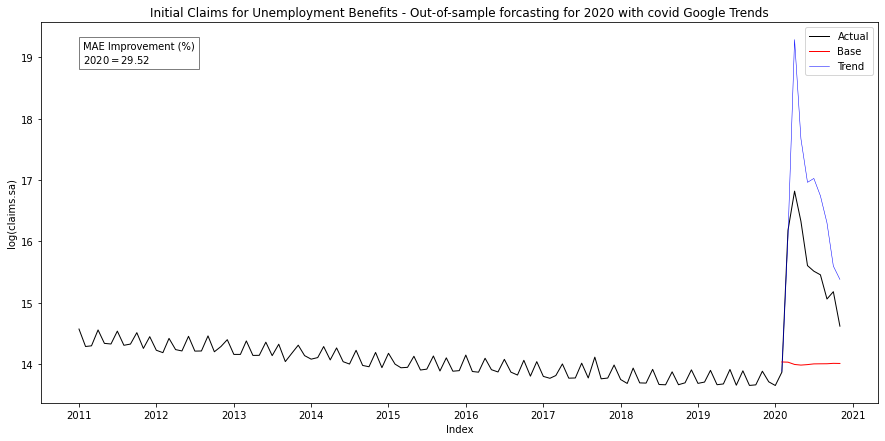

In [67]:
fig,ax = plt.subplots()
ax.plot(iclaims['DATE'],iclaims['ICSA'],color='black',label='Actual',linewidth=1)
ax.plot(df_new['DATE'],preds,linestyle='-',color='r',label='Base',linewidth=1)
ax.plot(df_new['DATE'],preds_trends_covid,color='b',linewidth=0.5,label='Trend')
plt.legend()
textstr = '\n'.join((
    r'MAE Improvement (%)',
    r'$2020=%.2f$'%(improvement_Covid,)))
    
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top',bbox=dict(facecolor='white', alpha=0.5))
ax.set_ylabel('log(claims.sa)')
ax.set_xlabel('Index')
ax.set_title('Initial Claims for Unemployment Benefits - Out-of-sample forcasting for 2020 with covid Google Trends')
fig.set_size_inches(15,7)
plt.show()

Here the improvement of the trends model compared to the base model is about **29.52%** (and we had before an improvement of 28.34% without the covid trend). **We can conclude that it not improves dramatically the predictions, but it does help a little.**

However, Google trends are very useful to predict anormal events that are related to a crisis, a particular event etc...

## Q3 : Has Google Trends the power to help us predict one-month-ahead movements of the USD/EUR rate ?

International transactions are usually settled in the near future. Exchange rate forecasts are necessary to evaluate the foreign denominated cash flows involved in international transactions. Thus, exchange rate forecasting is very important to evaluate the benefits and risks attached to the international business environment. Nowadays, developing a efficient tool to predict these kind of movements is really valorized.

Our main goal here is to find what kind of model could forecast exchange rates. We will build a model as in the paper (simple linear regression) but also use more complex ones basing us on the litterature. 

https://www.bauer.uh.edu/rsusmel/7386/ln5.pdf



## Data Management :

We have 5 data_sets, $4$ of them are the Google Trends for words related to the price level in US and 3 major European countries/regions (Great Britain, Germany, France). We will try to estimate if the variation of the price related trends between US and Europe can give us a good estimation of the USD/EUR rate movements.

### Cleaning our Datasets

In [68]:
# Load The datasets
ExRate = pd.read_csv('EXUSEU.csv')
TrendsUS = pd.read_csv('TrendsPrice_US.csv')
TrendsGB = pd.read_csv('TrendsPrice_GB.csv')
TrendsGR = pd.read_csv('TrendsPrice_Germany.csv')
TrendsFR = pd.read_csv('TrendsPrice_France.csv')

# Reshaping Each DataFrame
## US
TrendsUS = TrendsUS.reset_index()
TrendsUS.rename(columns = {'level_0':'Month','level_1':'Inflation','level_2':'Prices','level_3':'CPI','Catégorie\xa0: Toutes catégories':'Cheap'}, inplace = True)
TrendsUS = TrendsUS.drop([0])
TrendsUS = TrendsUS.reset_index().drop('index',axis=1)
## GB
TrendsGB = TrendsGB.reset_index()
TrendsGB.rename(columns = {'level_0':'Month','level_1':'Inflation','level_2':'Prices','level_3':'CPI','Catégorie\xa0: Toutes catégories':'Cheap'}, inplace = True)
TrendsGB = TrendsGB.drop([0])
TrendsGB = TrendsGB.reset_index().drop('index',axis=1)
## Germany
TrendsGR = TrendsGR.reset_index()
TrendsGR.rename(columns = {'level_0':'Month','level_1':'Inflation','level_2':'Prices','level_3':'CPI','Catégorie\xa0: Toutes catégories':'Cheap'}, inplace = True)
TrendsGR = TrendsGR.drop([0])
TrendsGR = TrendsGR.reset_index().drop('index',axis=1)
## France
TrendsFR = TrendsFR.reset_index()
TrendsFR.rename(columns = {'level_0':'Month','level_1':'Inflation','level_2':'Prices','level_3':'CPI','Catégorie\xa0: Toutes catégories':'Cheap'}, inplace = True)
TrendsFR = TrendsFR.drop([0])
TrendsFR = TrendsFR.reset_index().drop('index',axis=1)
print(TrendsFR.head())
print(' ')
print(' ')

# We replace <1 values by 0 and make sure that all our values are float for each DataFrame :
trends=['Inflation','Prices','CPI','Cheap']
for t in trends : 
    TrendsUS[t]=[float(s.replace('<\xa01','0')) for s in TrendsUS[t]]
    TrendsGB[t]=[float(s.replace('<\xa01','0')) for s in TrendsGB[t]]
    TrendsGR[t]=[float(s.replace('<\xa01','0')) for s in TrendsGR[t]]
    TrendsFR[t]=[float(s.replace('<\xa01','0')) for s in TrendsFR[t]]
print(TrendsFR.head())
print(' ')
print(' ')

     Month Inflation Prices  CPI Cheap
0  2004-01         1     47    1    11
1  2004-02         1     46    1    13
2  2004-03         1     47  < 1    11
3  2004-04         1     48    1    13
4  2004-05       < 1     52  < 1    14
 
 
     Month  Inflation  Prices  CPI  Cheap
0  2004-01        1.0    47.0  1.0   11.0
1  2004-02        1.0    46.0  1.0   13.0
2  2004-03        1.0    47.0  0.0   11.0
3  2004-04        1.0    48.0  1.0   13.0
4  2004-05        0.0    52.0  0.0   14.0
 
 


### Creating a unique European Trends Dataset

To do so, we consider that a good European trend estimator is the average of the 3 countries trends. 

In [69]:
## Now that our DataFrames are all clean and ready for use we average the values of each trends to one European trend
InflationUE =[]
PricesUE =[]
CPIUE=[]
CheapUE=[]

for i in range(len(TrendsGB)):
    InflationUE.append(statistics.mean([TrendsGR['Inflation'][i],TrendsGB['Inflation'][i],TrendsFR['Inflation'][i]]))
    PricesUE.append(statistics.mean([TrendsGR['Prices'][i],TrendsGB['Prices'][i],TrendsFR['Prices'][i]]))
    CPIUE.append(statistics.mean([TrendsGR['CPI'][i],TrendsGB['CPI'][i],TrendsFR['CPI'][i]]))
    CheapUE.append(statistics.mean([TrendsGR['Cheap'][i],TrendsGB['Cheap'][i],TrendsFR['Cheap'][i]]))

TrendsUE = pd.DataFrame({'Month':TrendsUS['Month'],'Inflation':InflationUE,'Prices':PricesUE,'CPI':CPIUE,'Cheap':CheapUE})

### Creating the Merged Dataset

We will evaluate the USD/EUR rate using as variables : a seasonnal term of 1 month before and the difference between US and Europe for each price related trends.

In [70]:
idx = ExRate.loc[ExRate['DATE'].isin(['2004-01-01'])].index.tolist()[0] 
ExRate_clean = ExRate[idx:].reset_index()
ExRate_clean['s1']=ExRate_clean['EXUSEU'].shift(1,axis=0,fill_value=0) # create seasonnal term for sa claims

data_rate = pd.DataFrame({'Month':TrendsUE['Month'][:len(TrendsUS)-1],
                          'EXUSEU':ExRate_clean['EXUSEU'],
                          'D_Inflation':(TrendsUS['Inflation'][:len(TrendsUS)-1]-TrendsUE['Inflation'][:len(TrendsUS)-1]),
                          'D_Prices':(TrendsUS['Prices'][:len(TrendsUS)-1]-TrendsUE['Prices'][:len(TrendsUS)-1]),
                          'D_CPI':(TrendsUS['CPI'][:len(TrendsUS)-1]-TrendsUE['CPI'][:len(TrendsUS)-1]),
                          'D_Cheap':(TrendsUS['Cheap'][:len(TrendsUS)-1]-TrendsUE['Cheap'][:len(TrendsUS)-1]),
                          's1':ExRate_clean['s1']
                         })

data_rate.Month = pd.to_datetime(data_rate.Month)
data_rate = data_rate.set_index(data_rate['Month'])
data_rate.index = pd.DatetimeIndex(data_rate.index.values,freq='MS') # Indicate that our index is sampled by weeks
data_rate.head()

,Month,EXUSEU,D_Inflation,D_Prices,D_CPI,D_Cheap,s1
2004-01-01,2004-01-01,1.2638,1.333333,-1.000000,1.333333,31.666667,0.0000
2004-02-01,2004-02-01,1.2640,1.666667,-0.666667,0.333333,32.000000,1.2638
2004-03-01,2004-03-01,1.2261,1.666667,3.000000,0.666667,32.333333,1.2640
2004-04-01,2004-04-01,1.1989,1.666667,3.666667,0.333333,27.000000,1.2261
2004-05-01,2004-05-01,1.2000,2.000000,9.333333,0.666667,31.666667,1.1989


### Baseline model :

We only use a seasonnal term $y_{t-1}$ for the linear regression.

In [71]:
mod = smf.ols(formula = 'EXUSEU ~ s1', data= data_rate[1:] )
res = mod.fit()
Predictions = res.predict()

### Trends model :

We use the seasonnal term $y_{t-1}$ and the variation of the Google Trends related to price between US and UE.

In [72]:
# Trends Model :
mod_trends = smf.ols(formula = 'EXUSEU ~ s1 + D_Inflation + D_Prices + D_CPI + D_Cheap ', data=data_rate[1:] )
res_trends = mod_trends.fit()
Predictions_trends = res_trends.predict()

### Using a rolling window :

In [73]:
#Rolling window with k = 10 observations.
k = 10

#Base model
preds=[]
for i in range(k,len(data_rate)): 
    x_train = data_rate.iloc[:i-1,:]
    mod = smf.ols(formula='EXUSEU ~ s1    ',data=x_train)
    res = mod.fit()
    pred = res.params[0] + res.params[1]*data_rate.s1[i]
    preds.append(pred)
    
#Trends model
preds_trend = []
for i in range(k,len(data_rate)): 
    x_train = data_rate.iloc[:i-1,:]
    mod = smf.ols(formula='EXUSEU ~ s1 + D_Inflation + D_Prices + D_CPI + D_Cheap',data=x_train)
    res = mod.fit()
    pred = res.params[0] + res.params[1]*data_rate['s1'][i] + res.params[2]*data_rate['D_Inflation'][i]+ res.params[3]*data_rate['D_Prices'][i] +res.params[4]*data_rate['D_CPI'][i] + res.params[5]*data_rate['D_Cheap'][i] 
    preds_trend.append(pred)

### MAEs :

We evaluate the overall MAEs as we don't know the turning points. Finding turning points will be one goal of the figure analysis.

In [74]:
mae_base_overall = mean_absolute_error(data_rate.EXUSEU[1:],Predictions)/(data_rate.EXUSEU.mean())
mae_trends_overall = mean_absolute_error(data_rate.EXUSEU[1:],Predictions_trends)/(data_rate.EXUSEU.mean())
improvement_overall = (mae_base_overall-mae_trends_overall)/mae_base_overall*100

mae_base_overall_wd = mean_absolute_error(data_rate.EXUSEU[k:],preds)/(data_rate.EXUSEU[k:].mean())
mae_trends_overall_wd = mean_absolute_error(data_rate.EXUSEU[k:],preds_trend)/(data_rate.EXUSEU[k:].mean())
improvement_overall_wd = (mae_base_overall_wd-mae_trends_overall_wd)/mae_base_overall_wd*100

In [75]:
print('Without Rolling Window')
print('')
print('Without the rolling window the MAE improvent is ',improvement_overall,'%')
print('MAE Trends Overall =',mae_trends_overall)
print('MAE Base Overall =',mae_base_overall)
print('')
print('With Rolling Window')
print('')
print('With the rolling window the MAE improvent is ',improvement_overall_wd,'%')
print('MAE Trends Overall =',mae_trends_overall_wd)
print('MAE Base Overall =',mae_base_overall_wd)

Without Rolling Window

Without the rolling window the MAE improvent is  1.4971793252543952 %
MAE Trends Overall = 0.016436642103976454
MAE Base Overall = 0.016686468459872764

With Rolling Window

With the rolling window the MAE improvent is  8.748366467695053 %
MAE Trends Overall = 0.04660566748171995
MAE Base Overall = 0.05107378978067345


### Plots :

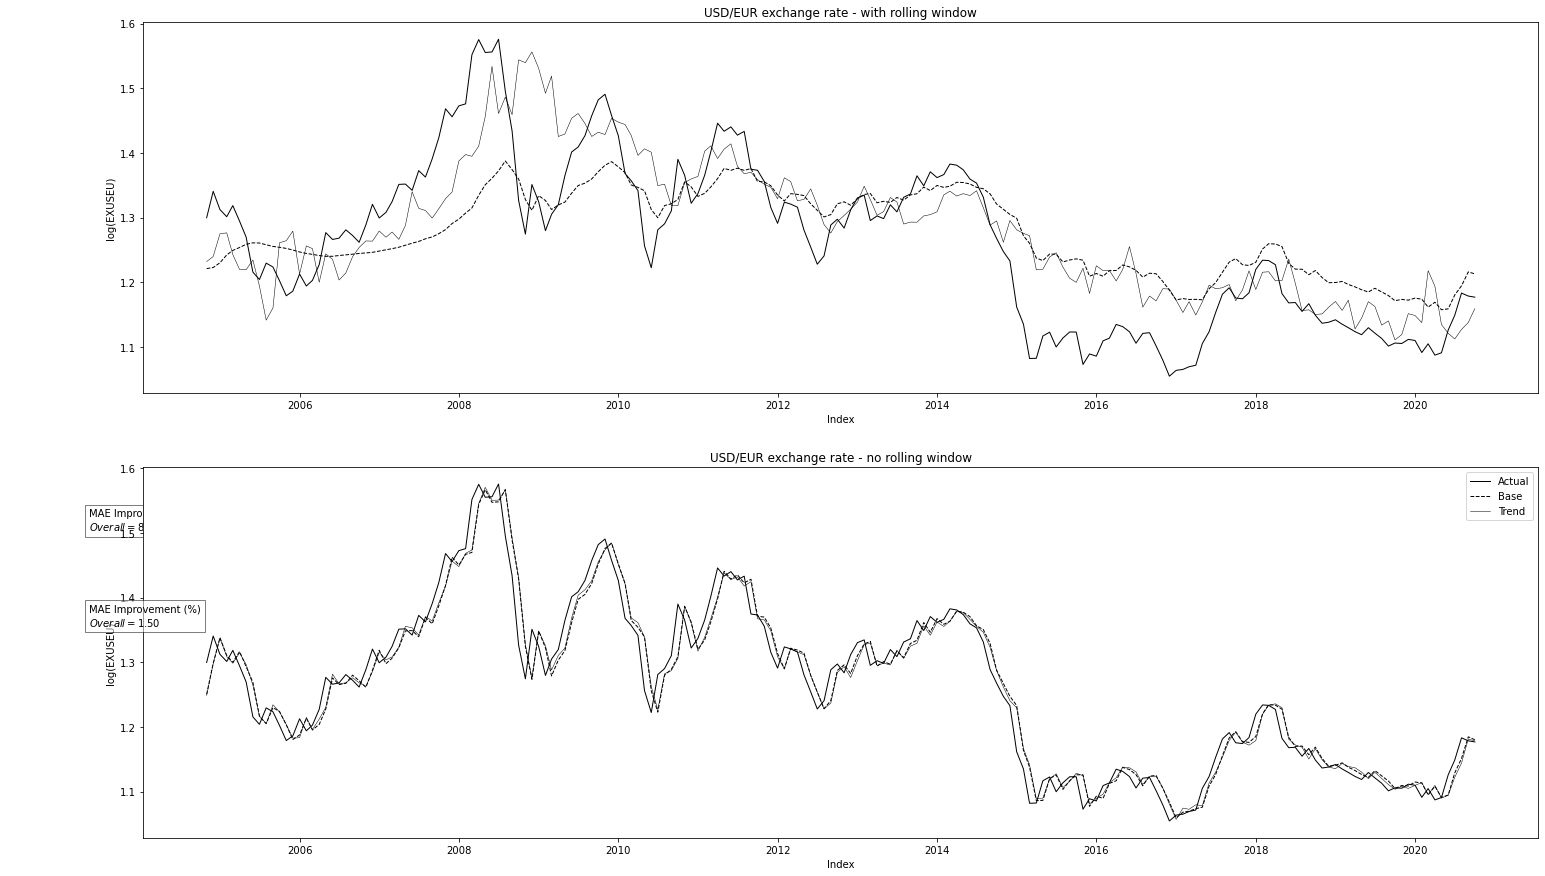

In [76]:
fig,axs = plt.subplots(2)
axs[0].plot(data_rate['Month'][k:],data_rate['EXUSEU'][k:],color='black',label='Actual',linewidth=1)
axs[0].plot(data_rate['Month'][k:],preds,linestyle='--',color='black',label='Base',linewidth=1)
axs[0].plot(data_rate['Month'][k:],preds_trend,color='black',linewidth=0.5,label='Trend')
textstr = '\n'.join((
    r'MAE Improvement (%)',
    r'$Overall=%.2f$'%(improvement_overall_wd,)))
    
axs[0].text(-0.055, 0.8, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top',bbox=dict(facecolor='white', alpha=0.5))
axs[0].set_ylabel('log(EXUSEU)')
axs[0].set_xlabel('Index')
axs[0].set_title('USD/EUR exchange rate - with rolling window')


axs[1].plot(data_rate['Month'][k:],data_rate['EXUSEU'][k:],color='black',label='Actual',linewidth=1)
axs[1].plot(data_rate['Month'][k:],Predictions[k-1:],linestyle='--',color='black',label='Base',linewidth=1)
axs[1].plot(data_rate['Month'][k:],Predictions_trends[k-1:],color='black',linewidth=0.5,label='Trend')

textstr1 = '\n'.join((
    r'MAE Improvement (%)',
    r'$Overall=%.2f$'%(improvement_overall,)))  
axs[1].text(-0.055, 0.55, textstr1, transform=ax.transAxes, fontsize=10,
        verticalalignment='top',bbox=dict(facecolor='white', alpha=0.5))
axs[1].set_ylabel('log(EXUSEU)')
axs[1].set_xlabel('Index')
axs[1].set_title('USD/EUR exchange rate - no rolling window')
plt.legend()


fig.set_size_inches(25,15)
plt.show()

### First Analysis and Definition of the Turning Points :

From the rolling window figure, we observe that each crash of the exchange rate is preceded by a rise of the rate. Thus we've decided to determinate whether the Google Trends can help predicting effictively the rise, the fall or both of them, compared to the Baseline model. We only consider a seasonnal term of one month before to be consisitent with the model of the previous questions.

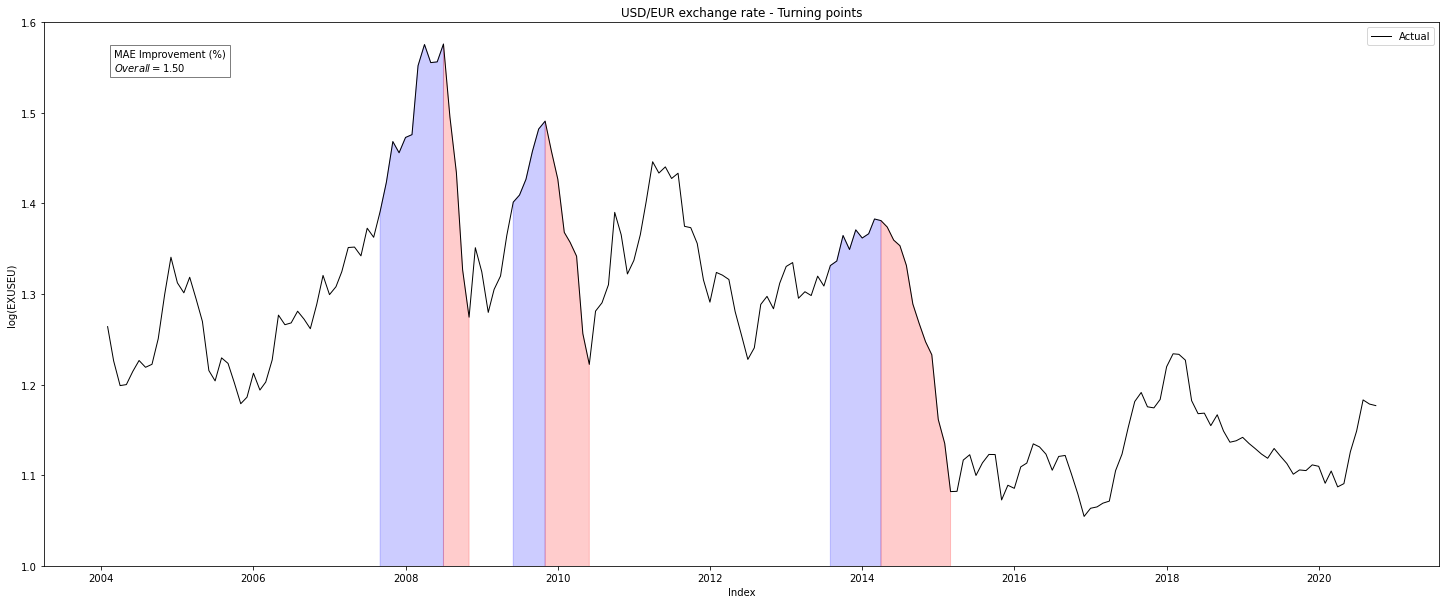

In [77]:
fig,ax = plt.subplots()
ax.plot(data_rate['Month'][1:],data_rate['EXUSEU'][1:],color='black',label='Actual',linewidth=1)

ax.fill_between(data_rate['Month']['2007-09-01':'2008-07-01'],data_rate['EXUSEU']['2007-09-01':'2008-07-01'], alpha = 0.2, color = 'blue')
ax.fill_between(data_rate['Month']['2009-06-01':'2009-11-01'],data_rate['EXUSEU']['2009-06-01':'2009-11-01'], alpha = 0.2, color = 'blue')
ax.fill_between(data_rate['Month']['2013-08-01':'2014-04-01'],data_rate['EXUSEU']['2013-08-01':'2014-04-01'], alpha = 0.2, color = 'blue')

ax.fill_between(data_rate['Month']['2008-07-01':'2008-11-01'],data_rate['EXUSEU']['2008-07-01':'2008-11-01'], alpha = 0.2, color = 'red')
ax.fill_between(data_rate['Month']['2009-11-01':'2010-06-01'],data_rate['EXUSEU']['2009-11-01':'2010-06-01'], alpha = 0.2, color = 'red')
ax.fill_between(data_rate['Month']['2014-04-01':'2015-03-01'],data_rate['EXUSEU']['2014-04-01':'2015-03-01'], alpha = 0.2, color = 'red')


textstr1 = '\n'.join((
    r'MAE Improvement (%)',
    r'$Overall=%.2f$'%(improvement_overall,)))  
ax.text(0.05, 0.95, textstr1, transform=ax.transAxes, fontsize=10,
        verticalalignment='top',bbox=dict(facecolor='white', alpha=0.5))
ax.set_ylabel('log(EXUSEU)')
ax.set_xlabel('Index')
ax.set_title('USD/EUR exchange rate - Turning points')
plt.legend()

plt.ylim([1, 1.6])
fig.set_size_inches(25,10)
plt.show()

### 2008 Crash :

In [78]:
#### Before the Crash :
#Baseline model
mod = smf.ols(formula = 'EXUSEU ~ s1', data= data_rate['2004-02-01':'2007-09-01'] )
res = mod.fit()
pred_bc = res.params[0] + res.params[1]*data_rate.s1['2007-09-01':'2008-07-01']

# Trends Model :
mod_trends = smf.ols(formula = 'EXUSEU ~ s1 + D_Inflation + D_Prices + D_CPI + D_Cheap ', data=data_rate['2004-02-01':'2007-09-01'] )
res_trends = mod_trends.fit()
pred_trends_bc = res_trends.params[0] + res_trends.params[1]*data_rate['s1']['2007-09-01':'2008-07-01'] + res_trends.params[2]*data_rate['D_Inflation']['2007-09-01':'2008-07-01']+ res_trends.params[3]*data_rate['D_Prices']['2007-09-01':'2008-07-01'] +res_trends.params[4]*data_rate['D_CPI']['2007-09-01':'2008-07-01'] + res_trends.params[5]*data_rate['D_Cheap']['2007-09-01':'2008-07-01']

#### During Crash :
#Baseline model
mod = smf.ols(formula = 'EXUSEU ~ s1', data= data_rate['2004-02-01':'2008-06-01'] )
res = mod.fit()
pred = res.params[0] + res.params[1]*data_rate.s1['2008-07-01':'2008-11-01']

# Trends Model :
mod_trends = smf.ols(formula = 'EXUSEU ~ s1 + D_Inflation + D_Prices + D_CPI + D_Cheap ', data=data_rate['2004-02-01':'2008-06-01'] )
res_trends = mod_trends.fit()
pred_trends = res_trends.params[0] + res_trends.params[1]*data_rate['s1']['2008-07-01':'2008-11-01'] + res_trends.params[2]*data_rate['D_Inflation']['2008-07-01':'2008-11-01']+ res_trends.params[3]*data_rate['D_Prices']['2008-07-01':'2008-11-01'] +res_trends.params[4]*data_rate['D_CPI']['2008-07-01':'2008-11-01'] + res_trends.params[5]*data_rate['D_Cheap']['2008-07-01':'2008-11-01'] 


### MAEs :
mae_base_overall_bc = mean_absolute_error(data_rate.EXUSEU['2007-09-01':'2008-07-01'],pred_bc)/(data_rate.EXUSEU['2007-09-01':'2008-07-01'].mean())
mae_trends_overall_bc = mean_absolute_error(data_rate.EXUSEU['2007-09-01':'2008-07-01'],pred_trends_bc)/(data_rate.EXUSEU['2007-09-01':'2008-07-01'].mean())
improvement_overall_bc = (mae_base_overall_bc-mae_trends_overall_bc)/mae_base_overall_bc*100

mae_base_overall = mean_absolute_error(data_rate.EXUSEU['2008-07-01':'2008-11-01'],pred)/(data_rate.EXUSEU['2008-07-01':'2008-11-01'].mean())
mae_trends_overall = mean_absolute_error(data_rate.EXUSEU['2008-07-01':'2008-11-01'],pred_trends)/(data_rate.EXUSEU['2008-07-01':'2008-11-01'].mean())
improvement_overall = (mae_base_overall-mae_trends_overall)/mae_base_overall*100

print(Fore.BLUE + 'Before Crash')
print('')
print('The MAE improvent is ',improvement_overall_bc,'%')
print('MAE Trends =',mae_trends_overall_bc)
print('MAE Base =',mae_base_overall_bc)
print('')
print(Fore.RED + 'During Crash')
print('')
print('The MAE improvent is ',improvement_overall,'%')
print('MAE Trends =',mae_trends_overall)
print('MAE Base =',mae_base_overall)

Before Crash

The MAE improvent is  -2.727808806734918 %
MAE Trends = 0.018922501431100785
MAE Base = 0.018420038012005382

During Crash

The MAE improvent is  -4.4368223850805935 %
MAE Trends = 0.051108535648704705
MAE Base = 0.04893727564810116


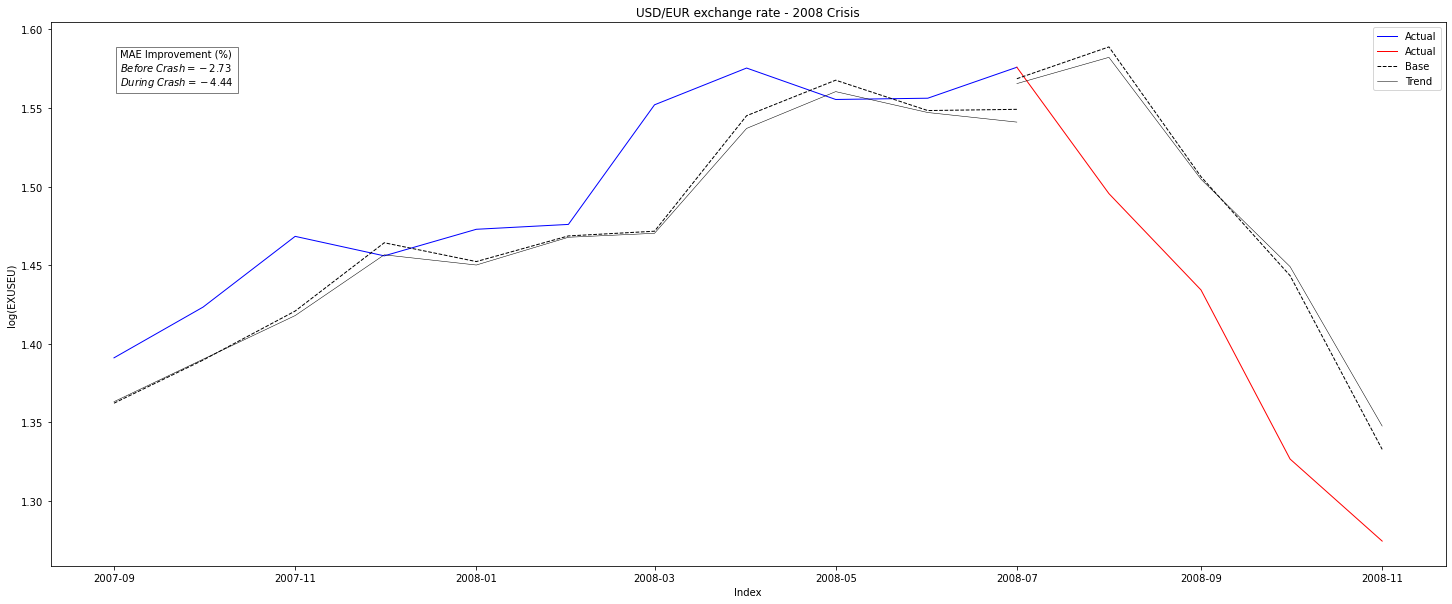

In [79]:
#Plots :
fig,ax = plt.subplots()
ax.plot(data_rate['Month']['2007-09-01':'2008-07-01'],data_rate['EXUSEU']['2007-09-01':'2008-07-01'],color='blue',label='Actual',linewidth=1)
ax.plot(data_rate['Month']['2007-09-01':'2008-07-01'],pred_bc,linestyle='--',color='black',linewidth=1)
ax.plot(data_rate['Month']['2007-09-01':'2008-07-01'],pred_trends_bc,color='black',linewidth=0.5)
ax.plot(data_rate['Month']['2008-07-01':'2008-11-01'],data_rate['EXUSEU']['2008-07-01':'2008-11-01'],color='red',label='Actual',linewidth=1)
ax.plot(data_rate['Month']['2008-07-01':'2008-11-01'],pred,linestyle='--',color='black',label='Base',linewidth=1)
ax.plot(data_rate['Month']['2008-07-01':'2008-11-01'],pred_trends,color='black',linewidth=0.5,label='Trend')
plt.legend()
textstr = '\n'.join((
    r'MAE Improvement (%)',
    r'$Before\;Crash=%.2f$'%(improvement_overall_bc,),
    r'$During\;Crash=%.2f$'%(improvement_overall,)))
    
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top',bbox=dict(facecolor='white', alpha=0.5))
ax.set_ylabel('log(EXUSEU)')
ax.set_xlabel('Index')
ax.set_title('USD/EUR exchange rate - 2008 Crisis')
fig.set_size_inches(25,10)
plt.show()

### 2010 Crash :

In [80]:
#### Before the Crash :
#Baseline model
mod = smf.ols(formula = 'EXUSEU ~ s1', data= data_rate['2004-02-01':'2009-05-01'] )
res = mod.fit()
pred_bc = res.params[0] + res.params[1]*data_rate.s1['2009-06-01':'2009-11-01']

# Trends Model :
mod_trends = smf.ols(formula = 'EXUSEU ~ s1 + D_Inflation + D_Prices + D_CPI + D_Cheap ', data=data_rate['2004-02-01':'2009-05-01'] )
res_trends = mod_trends.fit()
pred_trends_bc = res_trends.params[0] + res_trends.params[1]*data_rate['s1']['2009-06-01':'2009-11-01'] + res_trends.params[2]*data_rate['D_Inflation']['2009-06-01':'2009-11-01']+ res_trends.params[3]*data_rate['D_Prices']['2009-06-01':'2009-11-01'] +res_trends.params[4]*data_rate['D_CPI']['2009-06-01':'2009-11-01'] + res_trends.params[5]*data_rate['D_Cheap']['2009-06-01':'2009-11-01']


#### During Crash :
#Baseline model
mod = smf.ols(formula = 'EXUSEU ~ s1', data= data_rate['2004-02-01':'2009-10-01'] )
res = mod.fit()
pred = res.params[0] + res.params[1]*data_rate.s1['2009-11-01':'2010-06-01']

# Trends Model :
mod_trends = smf.ols(formula = 'EXUSEU ~ s1 + D_Inflation + D_Prices + D_CPI + D_Cheap ', data=data_rate['2004-02-01':'2009-10-01'] )
res_trends = mod_trends.fit()
pred_trends = res_trends.params[0] + res_trends.params[1]*data_rate['s1']['2009-11-01':'2010-06-01'] + res_trends.params[2]*data_rate['D_Inflation']['2009-11-01':'2010-06-01']+ res_trends.params[3]*data_rate['D_Prices']['2009-11-01':'2010-06-01'] +res_trends.params[4]*data_rate['D_CPI']['2009-11-01':'2010-06-01'] + res_trends.params[5]*data_rate['D_Cheap']['2009-11-01':'2010-06-01'] 


### MAEs :
mae_base_overall_bc = mean_absolute_error(data_rate.EXUSEU['2009-06-01':'2009-11-01'],pred_bc)/(data_rate.EXUSEU['2009-06-01':'2009-11-01'].mean())
mae_trends_overall_bc = mean_absolute_error(data_rate.EXUSEU['2009-06-01':'2009-11-01'],pred_trends_bc)/(data_rate.EXUSEU['2009-06-01':'2009-11-01'].mean())
improvement_overall_bc = (mae_base_overall_bc-mae_trends_overall_bc)/mae_base_overall_bc*100

mae_base_overall = mean_absolute_error(data_rate.EXUSEU['2009-11-01':'2010-06-01'],pred)/(data_rate.EXUSEU['2009-11-01':'2010-06-01'].mean())
mae_trends_overall = mean_absolute_error(data_rate.EXUSEU['2009-11-01':'2010-06-01'],pred_trends)/(data_rate.EXUSEU['2009-11-01':'2010-06-01'].mean())
improvement_overall = (mae_base_overall-mae_trends_overall)/mae_base_overall*100

print(Fore.BLUE + 'Before Crash')
print('')
print('The MAE improvent is ',improvement_overall_bc,'%')
print('MAE Trends =',mae_trends_overall_bc)
print('MAE Base =',mae_base_overall_bc)
print('')
print(Fore.RED + 'During Crash')
print('')
print('The MAE improvent is ',improvement_overall,'%')
print('MAE Trends =',mae_trends_overall)
print('MAE Base =',mae_base_overall)

Before Crash

The MAE improvent is  48.0038956261721 %
MAE Trends = 0.008953529836928601
MAE Base = 0.01721961663234782

During Crash

The MAE improvent is  -41.05356780266165 %
MAE Trends = 0.03701021204292184
MAE Base = 0.02623840900976024


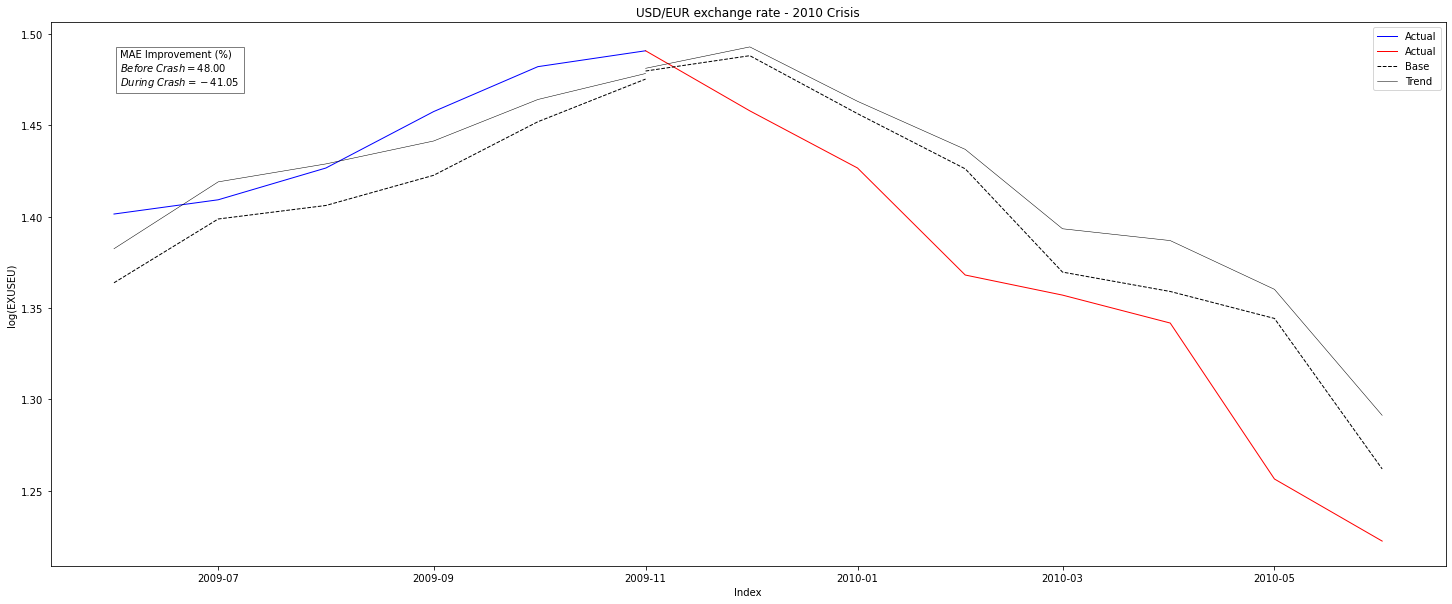

In [81]:
#Plots :
fig,ax = plt.subplots()
ax.plot(data_rate['Month']['2009-06-01':'2009-11-01'],data_rate['EXUSEU']['2009-06-01':'2009-11-01'],color='blue',label='Actual',linewidth=1)
ax.plot(data_rate['Month']['2009-06-01':'2009-11-01'],pred_bc,linestyle='--',color='black',linewidth=1)
ax.plot(data_rate['Month']['2009-06-01':'2009-11-01'],pred_trends_bc,color='black',linewidth=0.5)
ax.plot(data_rate['Month']['2009-11-01':'2010-06-01'],data_rate['EXUSEU']['2009-11-01':'2010-06-01'],color='red',label='Actual',linewidth=1)
ax.plot(data_rate['Month']['2009-11-01':'2010-06-01'],pred,linestyle='--',color='black',label='Base',linewidth=1)
ax.plot(data_rate['Month']['2009-11-01':'2010-06-01'],pred_trends,color='black',linewidth=0.5,label='Trend')
plt.legend()
textstr = '\n'.join((
    r'MAE Improvement (%)',
    r'$Before\;Crash=%.2f$'%(improvement_overall_bc,),
    r'$During\;Crash=%.2f$'%(improvement_overall,)))
    
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top',bbox=dict(facecolor='white', alpha=0.5))
ax.set_ylabel('log(EXUSEU)')
ax.set_xlabel('Index')
ax.set_title('USD/EUR exchange rate - 2010 Crisis')
fig.set_size_inches(25,10)
plt.show()

### 2014 Crash :

In [82]:
#### Before the Crash :
#Baseline model
mod = smf.ols(formula = 'EXUSEU ~ s1', data= data_rate['2004-02-01':'2013-08-01'] )
res = mod.fit()
pred_bc = res.params[0] + res.params[1]*data_rate.s1['2013-08-01':'2014-04-01']

# Trends Model :
mod_trends = smf.ols(formula = 'EXUSEU ~ s1 + D_Inflation + D_Prices + D_CPI + D_Cheap ', data=data_rate['2004-02-01':'2013-08-01'] )
res_trends = mod_trends.fit()
pred_trends_bc = res_trends.params[0] + res_trends.params[1]*data_rate['s1']['2013-08-01':'2014-04-01'] + res_trends.params[2]*data_rate['D_Inflation']['2013-08-01':'2014-04-01']+ res_trends.params[3]*data_rate['D_Prices']['2013-08-01':'2014-04-01'] +res_trends.params[4]*data_rate['D_CPI']['2013-08-01':'2014-04-01'] + res_trends.params[5]*data_rate['D_Cheap']['2013-08-01':'2014-04-01']

#### During the Crash :
#Baseline model
mod = smf.ols(formula = 'EXUSEU ~ s1', data= data_rate['2004-02-01':'2014-03-01'] )
res = mod.fit()
pred = res.params[0] + res.params[1]*data_rate.s1['2014-04-01':'2015-03-01']

# Trends Model :
mod_trends = smf.ols(formula = 'EXUSEU ~ s1 + D_Inflation + D_Prices + D_CPI + D_Cheap ', data=data_rate['2004-02-01':'2014-03-01'] )
res_trends = mod_trends.fit()
pred_trends = res_trends.params[0] + res_trends.params[1]*data_rate['s1']['2014-04-01':'2015-03-01'] + res_trends.params[2]*data_rate['D_Inflation']['2014-04-01':'2015-03-01']+ res_trends.params[3]*data_rate['D_Prices']['2014-04-01':'2015-03-01'] +res_trends.params[4]*data_rate['D_CPI']['2014-04-01':'2015-03-01'] + res_trends.params[5]*data_rate['D_Cheap']['2014-04-01':'2015-03-01'] 


### MAEs :
mae_base_overall_bc = mean_absolute_error(data_rate.EXUSEU['2013-08-01':'2014-04-01'],pred_bc)/(data_rate.EXUSEU['2013-08-01':'2014-04-01'].mean())
mae_trends_overall_bc = mean_absolute_error(data_rate.EXUSEU['2013-08-01':'2014-04-01'],pred_trends_bc)/(data_rate.EXUSEU['2013-08-01':'2014-04-01'].mean())
improvement_overall_bc = (mae_base_overall_bc-mae_trends_overall_bc)/mae_base_overall_bc*100

mae_base_overall = mean_absolute_error(data_rate.EXUSEU['2014-04-01':'2015-03-01'],pred)/(data_rate.EXUSEU['2014-04-01':'2015-03-01'].mean())
mae_trends_overall = mean_absolute_error(data_rate.EXUSEU['2014-04-01':'2015-03-01'],pred_trends)/(data_rate.EXUSEU['2014-04-01':'2015-03-01'].mean())
improvement_overall = (mae_base_overall-mae_trends_overall)/mae_base_overall*100

print(Fore.BLUE + 'Before Crash')
print('')
print('The MAE improvent is ',improvement_overall_bc,'%')
print('MAE Trends =',mae_trends_overall_bc)
print('MAE Base =',mae_base_overall_bc)
print('')
print(Fore.RED + 'During Crash')
print('')
print('The MAE improvent is ',improvement_overall,'%')
print('MAE Trends =',mae_trends_overall)
print('MAE Base =',mae_base_overall)

Before Crash

The MAE improvent is  14.7160210128514 %
MAE Trends = 0.00846046243631021
MAE Base = 0.00992034205813159

During Crash

The MAE improvent is  -25.216012720425233 %
MAE Trends = 0.028325165885069916
MAE Base = 0.022621041246787373


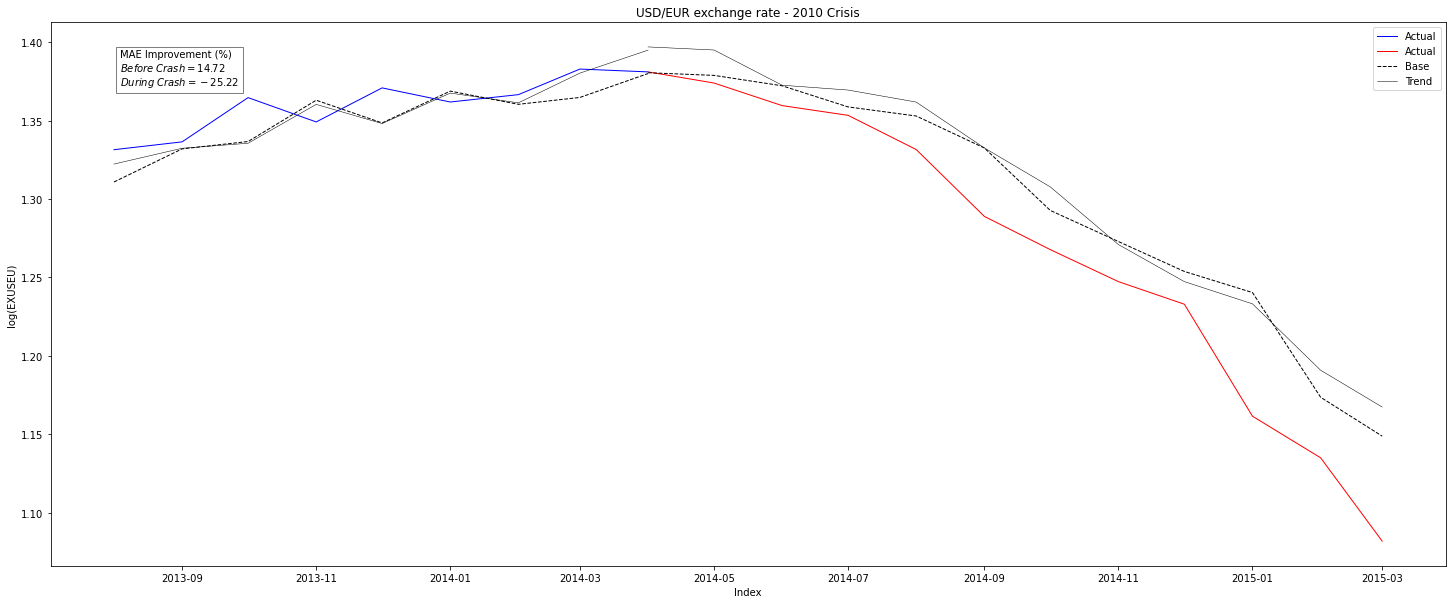

In [83]:
#Plots :
fig,ax = plt.subplots()
ax.plot(data_rate['Month']['2013-08-01':'2014-04-01'],data_rate['EXUSEU']['2013-08-01':'2014-04-01'],color='blue',label='Actual',linewidth=1)
ax.plot(data_rate['Month']['2013-08-01':'2014-04-01'],pred_bc,linestyle='--',color='black',linewidth=1)
ax.plot(data_rate['Month']['2013-08-01':'2014-04-01'],pred_trends_bc,color='black',linewidth=0.5)
ax.plot(data_rate['Month']['2014-04-01':'2015-03-01'],data_rate['EXUSEU']['2014-04-01':'2015-03-01'],color='red',label='Actual',linewidth=1)
ax.plot(data_rate['Month']['2014-04-01':'2015-03-01'],pred,linestyle='--',color='black',label='Base',linewidth=1)
ax.plot(data_rate['Month']['2014-04-01':'2015-03-01'],pred_trends,color='black',linewidth=0.5,label='Trend')
plt.legend()
textstr = '\n'.join((
    r'MAE Improvement (%)',
    r'$Before\;Crash=%.2f$'%(improvement_overall_bc,),
    r'$During\;Crash=%.2f$'%(improvement_overall,)))
    
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top',bbox=dict(facecolor='white', alpha=0.5))
ax.set_ylabel('log(EXUSEU)')
ax.set_xlabel('Index')
ax.set_title('USD/EUR exchange rate - 2010 Crisis')
fig.set_size_inches(25,10)
plt.show()

# Conclusion 

